In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all words
words = open('../../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to and from integers
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3

def build_dataset(words):
    X,Y = [], []

    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            index = stoi[ch]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X  = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape) # examples made from words
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) # 80% of dataset 
n2 = int(0.9 * len(words)) # 90% of dataset

Xtr, Ytr = build_dataset(words[:n1]) # 0 to 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 80% to 90% = 10%
Xte, Yte = build_dataset(words[n2:]) # 90% to 100% = 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10
n_hidden =200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g) 

# taking the same set of parameters
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[index], Ytr[index]
    
    # forward pass
    embedding = C[Xb] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    embcat = embedding.view(embedding.shape[0],-1)
    hidden_layer_preactivation = embcat @ W1 + b1
    hidden_layer = torch.tanh(hidden_layer_preactivation)
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # each minibatch for each Y
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    lossi.append(loss.log10().item())

      0/ 200000:27.881733


  10000/ 200000:2.969217
  20000/ 200000:2.538102
  30000/ 200000:2.840773
  40000/ 200000:2.027658
  50000/ 200000:2.459033
  60000/ 200000:2.494352
  70000/ 200000:2.133847
  80000/ 200000:2.402956
  90000/ 200000:2.350247
 100000/ 200000:2.044674
 110000/ 200000:2.392169
 120000/ 200000:1.916288
 130000/ 200000:2.349328
 140000/ 200000:2.270954
 150000/ 200000:2.167137
 160000/ 200000:2.076604
 170000/ 200000:1.811191
 180000/ 200000:2.016870
 190000/ 200000:1.881849


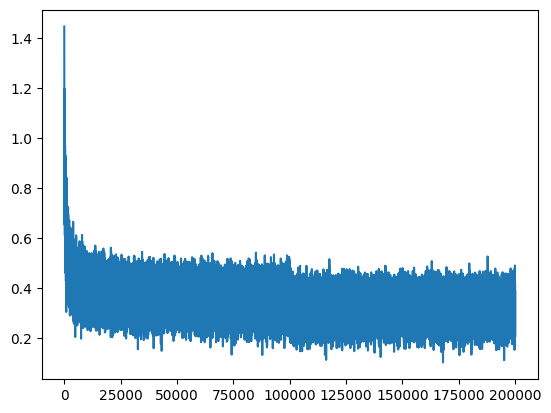

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # disables gradient tracking. implicitly advising not to keep track of the grad under the hood since we wont be anyway backtracking this.
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    embedding = C[x]
    embeddingCat = embedding.view(embedding.shape[0], -1)  # concat to (N, block_size * n_emb)
    h = torch.tanh(embeddingCat @ W1 + b1)  # Matrix multiplication instead of element-wise
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.124457836151123
val 2.1642823219299316


In [10]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all zeros
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)    
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break onn sampling the special character ' . '
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


junide.
jayceah.
presay.
adin.
koi.
roto.
sabe.
tee.
kalinaa.
zamilena.
jededailewintlessiyanayla.
terinleem.
kyn.
demmerchinsleigh.
ani.
core.
yarion.
kaelandreed.
moilmayniquan.
asnossiia.


Scrutinizing the initialisation. 

It is improperly configured. 
When we look at the initial loss value we see: <br>
<pre>     0/ 200000 : 27.881733 <br></pre>
which is a very big value and then we suddenly see a rapid dip to 2. something which is not right. <br>

At initialisation, we have 27 characters that could come for anyone training example and at that time we do not have any such reason to believe any character is highly likely than others so we would expect any probability distribution that would come out initially will be a uniform distribution assigning equal probability for all the 27 characters.

So the probability we would be expecting for each one of these characters is 1/27.0 and the loss is ```- torch.tensor(1/27.0).log()```

In [11]:
- torch.tensor(1/27.0).log()

tensor(3.2958)

We got the earlier <pre>27.881733</pre> because the whole network is really confused, its confident about some characters while not confident about others and the network because confidently wrong causing it to record a very high loss.

In [12]:
# 4 dimensional example of the issue
# we have only 4 characters
logits = torch.tensor([0.0,0.0,0.0,0.0]) # these come out of neural network nd they r very close to 0
probs = torch.softmax(logits, dim=0)# on taking the softmax of 0's, we get probabiltiies which are diffuse distribution
# the above values(probs) sums to 1 and exactly uniform
loss = -probs[2].log() # manipulating logits we could change the loss
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

If we change the logits value of [2] to something like 2 or 5. It could be like we are locking out and by chance this could be a very high number like this nd then we would record a very high loss because we are assigning the correct probability at the initialisation by chance to the correct label

In [13]:
logits = torch.tensor([0.0,0.0,5.0,0.0]) 
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

If we change the logits value of [1] instead of [2] to something like 2 or 5 then we will see that it will be recording a much higher, extreme loss

In [14]:
logits = torch.tensor([0.0,5.0,0.0,0.0]) 
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

In [15]:
logits = torch.randn(4) # normally distributed values
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 0.1717,  0.6351, -1.0602,  0.2569]),
 tensor([0.2519, 0.4004, 0.0735, 0.2743]),
 tensor(2.6107))

Since most of the values that come out of logits are near 0, the loss came out is ok

In [16]:
logits = torch.randn(4)*10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 4.5259,  7.3689,  8.6339, -3.6535]),
 tensor([1.2660e-02, 2.1733e-01, 7.7001e-01, 3.5494e-06]),
 tensor(0.2614))

But for these more extreme values, its very unlikely to get the correct bucket.

But this doesn't mean the logits have to be 0 all the time, it could be equal and produce the same effect. This is because we need a uniform distribution. Because of the normalisation inside softmax, it will actually come out ok.

In [17]:
logits = torch.tensor([1.0,1.0,1.0,1.0]) 
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([1., 1., 1., 1.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

So step1 is to understand where all this went wrong

In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[index], Ytr[index]
    
    # forward pass
    embedding = C[Xb] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    embcat = embedding.view(embedding.shape[0],-1)
    hidden_layer_preactivation = embcat @ W1 + b1
    hidden_layer = torch.tanh(hidden_layer_preactivation)
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # each minibatch for each Y
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    lossi.append(loss.log10().item())
    break # breaking after the first step

      0/ 200000:2.371111


In [19]:
logits[0]

tensor([10.5381,  6.2339,  4.3079,  3.2215,  5.4490,  5.4035,  1.4245,  3.5824,
         8.7619,  6.0510,  4.4050,  3.8609,  8.4166,  6.2522,  9.5774,  2.7537,
         3.0345,  0.9746,  7.4852,  7.0189,  4.8495,  5.2211,  4.4516,  3.7679,
         0.1164,  5.1434,  3.5821], grad_fn=<SelectBackward0>)

From this, we understand that the logits are extreme values and that creates the fake confidence and incorrect answers and makes the loss get very very high. So we want to have the logits that come out of this net to be more closer to 0

### Optimisation by adjusting the weights (scaling down) and setting the bias to 0

In [20]:
# MLP revisited
n_embd = 10
n_hidden =200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01 # scaling down thse values from 1 to 0.1 to 0.01
b2 = torch.randn(vocab_size, generator=g) * 0 

# taking the same set of parameters
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [21]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[index], Ytr[index]
    
    # forward pass
    embedding = C[Xb] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    embcat = embedding.view(embedding.shape[0],-1)
    hidden_layer_preactivation = embcat @ W1 + b1
    hidden_layer = torch.tanh(hidden_layer_preactivation)
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # each minibatch for each Y
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    lossi.append(loss.log10().item())
    break # breaking after the first step

      0/ 200000:3.322059


In [22]:
logits[0]

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

logits are also closed to 0. We are growing much closer to what we expect (1/27.0 = 3.29)

if W2 = _ * 0.1 then we get 4.23 <br>
if it was * 0.01 then we get 3.32

If we * 0 to W2 , it would give the exact value and it might be right in case of this output layer, but it may cause some problems in some situations. This is given for a symmetry breaking.

In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[index], Ytr[index]
    
    # forward pass
    embedding = C[Xb] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    embcat = embedding.view(embedding.shape[0],-1)
    hidden_layer_preactivation = embcat @ W1 + b1
    hidden_layer = torch.tanh(hidden_layer_preactivation)
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # each minibatch for each Y
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    lossi.append(loss.log10().item())


      0/ 200000:3.185710
  10000/ 200000:1.869976
  20000/ 200000:1.925167
  30000/ 200000:2.056973
  40000/ 200000:2.207332
  50000/ 200000:2.132500
  60000/ 200000:2.153293
  70000/ 200000:2.802884
  80000/ 200000:2.654410
  90000/ 200000:2.293141
 100000/ 200000:2.281344
 110000/ 200000:1.862925
 120000/ 200000:2.169475
 130000/ 200000:1.969287
 140000/ 200000:1.804307
 150000/ 200000:2.448285
 160000/ 200000:2.223784
 170000/ 200000:1.778775
 180000/ 200000:1.920709
 190000/ 200000:2.160146


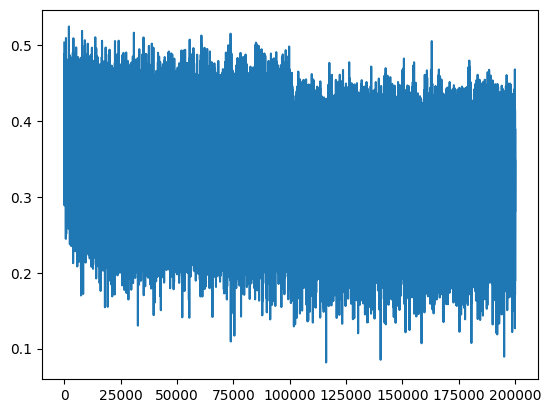

In [24]:
plt.plot(lossi)

Plot of the loss doesn't have the hockey shape because in the very first few iterations of the loss during the optimisation is that the optimisation squashes down the logits nd rearranging the logits. So here we took avay the easy part of loss fn where the weights were just shrunk down and therefore we dont get the easy gains at the beginning, but we are getting the hard gains of training the actual neural net

In [25]:
@torch.no_grad() # disables gradient tracking. implicitly advising not to keep track of the grad under the hood since we wont be anyway backtracking this.
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    embedding = C[x]
    embeddingCat = embedding.view(embedding.shape[0], -1)  # concat to (N, block_size * n_emb)
    h = torch.tanh(embeddingCat @ W1 + b1)  # Matrix multiplication instead of element-wise
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
# loss is improved from 2.16 to 2.13

train 2.0695769786834717
val 2.131199836730957


In [26]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all zeros
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)    
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break onn sampling the special character ' . '
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


junide.
jaycand.
presayleigh.
kai.
ronorian.
arett.
samela.
zamilena.
jadeyaire.
amellseen.
evy.
artez.
aveumahaf.
demmerppynsleigh.
ann.
core.
yarion.
kaelandreed.
mois.
wyn.


### Fixing the saturated tanh

In [27]:
# MLP revisited
n_embd = 10
n_hidden =200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01 # scaling down thse values from 1 to 0.1 to 0.01
b2 = torch.randn(vocab_size, generator=g) * 0 

# taking the same set of parameters
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[index], Ytr[index]
    
    # forward pass
    embedding = C[Xb] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    embcat = embedding.view(embedding.shape[0],-1)
    hidden_layer_preactivation = embcat @ W1 + b1
    hidden_layer = torch.tanh(hidden_layer_preactivation)
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # each minibatch for each Y
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000:3.322059


Activations of the hidden layer has many elements with value 1

In [29]:
hidden_layer

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

One thing to remember is tanh is a squashing function, it takes arbitrary numbers and it squashes them into a range of -1 and 1 and it does so smoothly

In [30]:
hidden_layer.view(-1).shape # stretched out into a 1 large vector

torch.Size([6400])

In [31]:
hidden_layer.view(-1).tolist() # one large python list of floats

[0.8100222945213318,
 -0.8996702432632446,
 -0.999309241771698,
 0.9980825185775757,
 -0.6508485078811646,
 -0.6897538304328918,
 -0.9619210362434387,
 -0.9999876022338867,
 -0.3420684039592743,
 0.999920666217804,
 0.9999915957450867,
 -0.9980642199516296,
 0.9876819252967834,
 0.8998497128486633,
 0.8862370252609253,
 0.7360541820526123,
 -0.9959285855293274,
 -0.981837809085846,
 -0.989227294921875,
 0.9997955560684204,
 -0.9220333695411682,
 -0.8541557192802429,
 0.0639711245894432,
 0.9999996423721313,
 0.9979971051216125,
 -0.9949458837509155,
 0.9996280670166016,
 -0.9998515844345093,
 0.6444535255432129,
 0.7554441690444946,
 -0.9997296929359436,
 0.9996114373207092,
 0.9912618398666382,
 0.9449755549430847,
 0.9999983310699463,
 -0.9999998211860657,
 0.9999754428863525,
 -0.9999991059303284,
 1.0,
 -0.5565183758735657,
 0.9787917137145996,
 -0.9885085225105286,
 0.9983248710632324,
 -0.9999771118164062,
 -0.03651892766356468,
 0.9999677538871765,
 0.9990684986114502,
 -0.72501

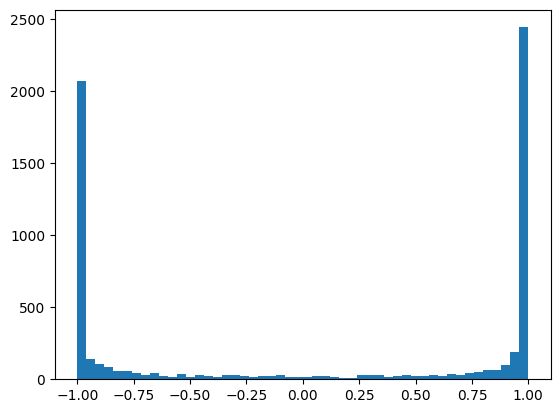

In [32]:
plt.hist(hidden_layer.view(-1).tolist(),50); # ; suppresses a bunch of values we dont want

By taking the histogram of h we will get a better idea of distribution of the values inside the tensor.
From this we understand that most of the values take on the value of -1 and 1 meaning tanh is very very active

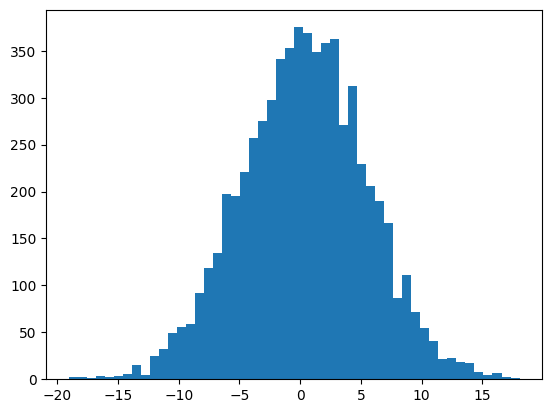

In [33]:
plt.hist(hidden_layer_preactivation.view(-1).tolist(),50);

The distribution of the pre activations is very very broad taking numbers between -15 nd 15 and thats why in the torch.tanh everything is being squashed and capped to be in the range of -1 nd 1 and and lots of numbers in betweent take on extreme values.

During backpropogation, we are ding backward pass starting at the loss and flowing through the network backwards in particular we are going to backpropogate through this torch.tanh and this hidden layer is made up of 200 neurons for each one of these examples and it implements an element wise tanh

```python 
def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
        self.grad += (1 - t**2) * out.grad
    out._backward = _backward
```

This is the code for backward propogation of a tanh fn. <br>
Here x is the input and t is output of the tanh which is in between -1 and 1. <br>
To backpropogate, we take out the grad and multiply it with the local gradient $(1 - t^{2})$ (chain rule).

If the outputs of tanh are very close 1 and -1, then it would cause  a 0 for the grad $(1- 1^{2})$ is nothing but 0. This may cause always 0 no matter what the value of out.grad is. This inturn would be interpreted as a disruption to the backpropogation through this tanh unit.

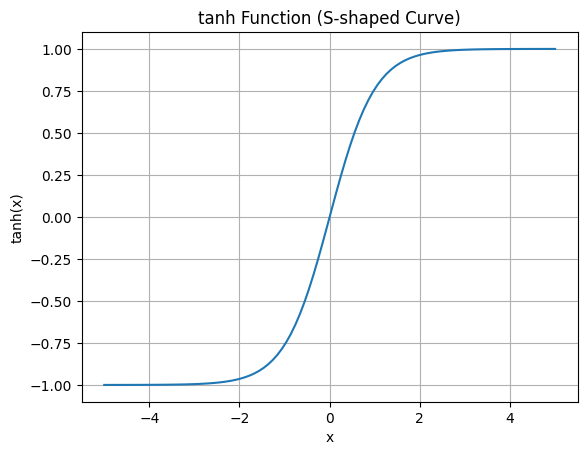

In [34]:
# Generate a range of values from -5 to 5 with 100 points
x = torch.linspace(-5, 5, 100)
y = torch.tanh(x)

# Plot the S-shaped tanh curve
plt.plot(x.numpy(), y.numpy())
plt.title("tanh Function (S-shaped Curve)")
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.grid(True)
plt.show()


Analysing it intuitively, we understand that the values that are close to 1 fall in that flat area region/ the tail area. So changing the input is not going to impact the output of tanh much because its in the flat region of tanh and therefore there is no impact on the loss.So the weights and biases along with the tanh neuron do not impact the loss.

This proves that the gradient will eventually become 0 and vanishes and the grad will pass through as it is when the tanh becomes 0.

- If t = 0, tanh is inactive <br>
- More in the flat tail means more the gradient is squashed.

We can say finally that the gradient flowing through tanh can only decrease in the amt and decrease in amt is proportional through a square here depending on how far we are in the flat tails of the tanh

So the concern here, if almost all elements of hidden layer is 1 and the hidden layer just passes these gradients through, the network will get just destroyed at this layer

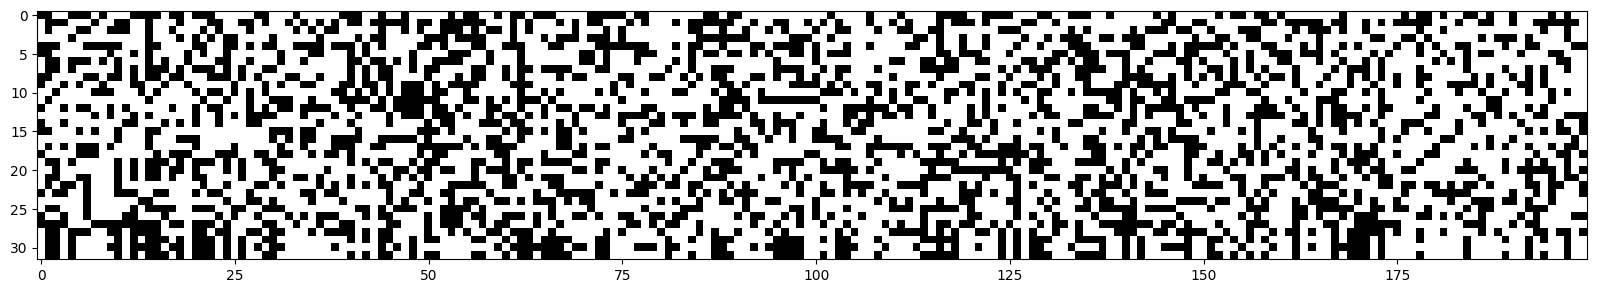

In [35]:
plt.figure(figsize=(20,10))
plt.imshow(hidden_layer.abs() > 0.99, cmap = 'gray', interpolation='nearest')

Gives us an understanding as to how often the network is in the flat region <br>
This is a boolean tensor <br>
<pre>   hidden_layer.abs() > 0.99</pre> 
This will cause a light region if its true and dark if its false <br>
There is having 32 examples and then 200 hidden neurons.<br>

This gives us much more of a proof that the network was in the flat tail region for the longest time and therefore gradient would get destroyed.

It would have been a bigger trouble, if for anyone of the 200 neurons have a column fully white then it would mean that it is a dead neuron. This could be a tanh neuronw where the initialisation of the weights and biases could be such that no single example would ever activate the tanh in the active part of tanh if all the examples land in the tail then this neuron would never learn and this would be a dead neuron. This means whatever the weights or bias is tanh will just not learn because all the gradients will zeroed out. But luckily no such example is there

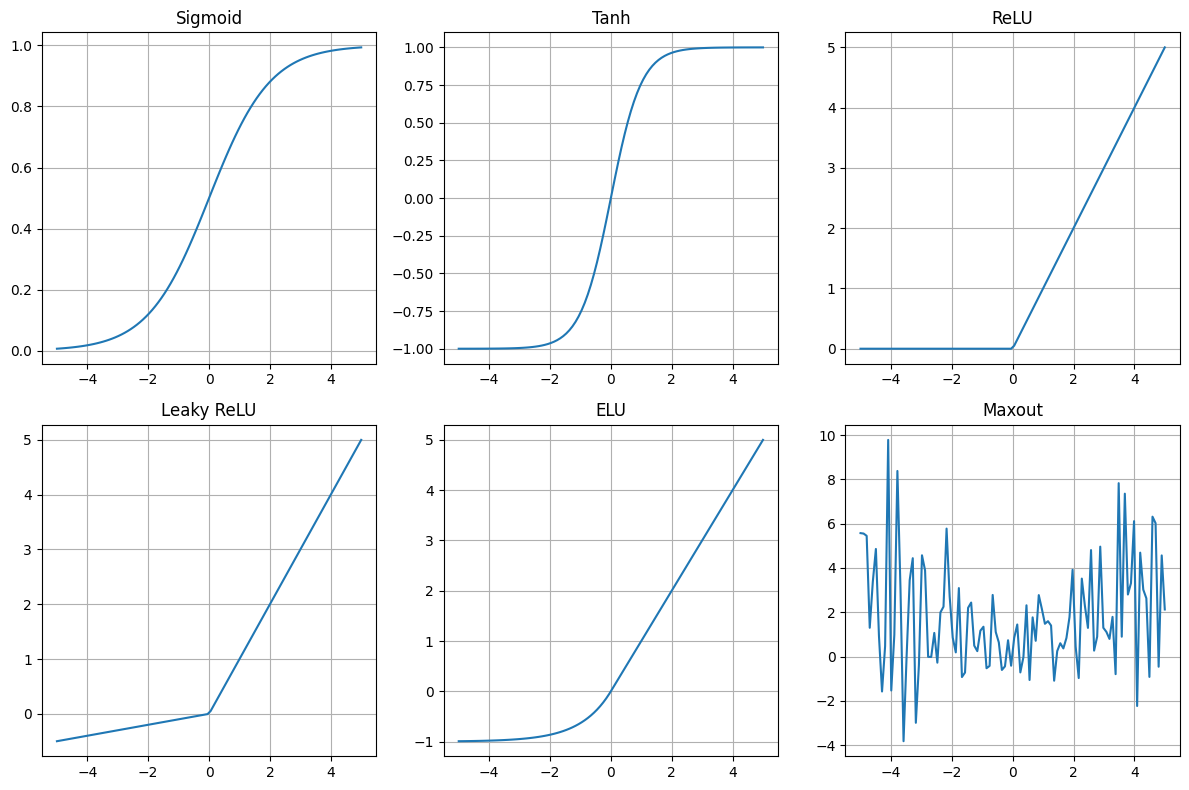

In [36]:
# Define the range of x values
x = torch.linspace(-5, 5, 100)

# Define the activation functions
activations = {
    "Sigmoid": torch.sigmoid(x),
    "Tanh": torch.tanh(x),
    "ReLU": F.relu(x),
    "Leaky ReLU": F.leaky_relu(x, negative_slope=0.1),
    "ELU": F.elu(x),
}

# Define Maxout manually (since it's not directly available in PyTorch)
# Maxout generally takes two or more linear functions and outputs the maximum
# Here we simulate it with two linear transformations for simplicity
# maxout is max(w1^T * x + b1, w2^T * x + b2) 
W1 = torch.randn(100)
b1 = torch.randn(100)
W2 = torch.randn(100)
b2 = torch.randn(100)
maxout = torch.max(x * W1 + b1, x * W2 + b2)
activations["Maxout"] = maxout

# Create the grid of plots
plt.figure(figsize=(12, 8))

for i, (name, y) in enumerate(activations.items(), 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns, i-th subplot
    plt.plot(x.numpy(), y.numpy())
    plt.title(name)
    plt.grid(True)

plt.tight_layout()
plt.show()


- Sigmoid is similar to tanh since its also a squashing neuron <br><br>
- ReLU has a flat region below 0 meaning it pass through if it is positive and if the pre-activation is negative, it will just shut it off/ flatten. Therefore similar to tanh.<br><br>
     -  If a neuron with a ReLU nonlinearity never activates, so for any examples that you plug in to the dataset, it never turns on and its always in the flat region then its a dead neuron.<br>
     - This could happen in situations of initialisation because the weights and biases just make it so that by chance some neurons are forever dead but it could happen in case of optimisation if you have like a too high of a learning rate, sometimes we could neurons that gets too much of a gradient and they get knocked out off the data manifold causing no example to ever activate this neuron so its kind of a permanent damage.<br>
     - There could be situations when the Learning rate is too high and the neural net with ReLU neurons you train the net and we get some loss but on then going back throught the entire training set and on forwarding the examples and we can find the neurons that never activate. There are some dead neurons in the network and those neurons will never turn on and usually during the training, the ReLu neurons move and change and then because of the high gradient somewhere by chance could have been knocked off and then onwards nothing activates them and they are dead <br>
- Leaky ReLU, Maxout and ELU: Since it doesnt have flat areas, its fine<br>


Coming to our point, we dont want such a  saturated value from tanh in both sides of the graph because this means we have done less training for these neurons because they update less frequently

```python
    hidden_layer_preactivation = embcat @ W1 + b1
    hidden_layer = torch.tanh(hidden_layer_preactivation)
```

hidden_layer_preactivation is a uniform gaussian multiplied by W1 and summed to b1 and it is too far from 0 and thats causing the issue. But we want to have it really close to 0 like the logits

In [37]:
# MLP revisited
n_embd = 10
n_hidden =200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g) 
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01 # keeping a bit of entropy
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01 # scaling down thse values from 1 to 0.1 to 0.01
b2 = torch.randn(vocab_size, generator=g) * 0 

# taking the same set of parameters
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [38]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[index], Ytr[index]
    
    # forward pass
    embedding = C[Xb] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    embcat = embedding.view(embedding.shape[0],-1)
    hidden_layer_preactivation = embcat @ W1 + b1
    hidden_layer = torch.tanh(hidden_layer_preactivation)
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # each minibatch for each Y
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    lossi.append(loss.log10().item())

      0/ 200000:3.313459


  10000/ 200000:2.164827
  20000/ 200000:2.306089
  30000/ 200000:2.454139
  40000/ 200000:1.978676
  50000/ 200000:2.292972
  60000/ 200000:2.423232
  70000/ 200000:2.067997
  80000/ 200000:2.309545
  90000/ 200000:2.120710
 100000/ 200000:1.826862
 110000/ 200000:2.204488
 120000/ 200000:1.979652
 130000/ 200000:2.394567
 140000/ 200000:2.100050
 150000/ 200000:2.194798
 160000/ 200000:1.861945
 170000/ 200000:1.780918
 180000/ 200000:1.967283
 190000/ 200000:1.829466


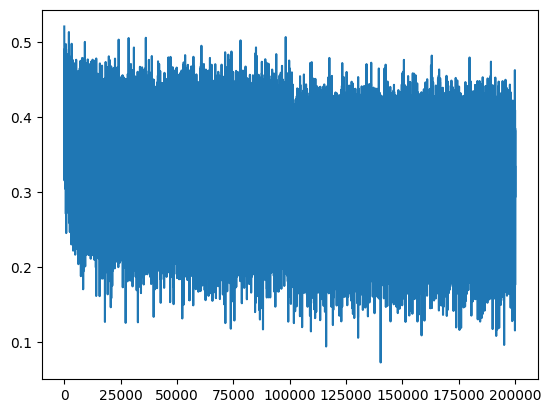

In [39]:
plt.plot(lossi)

In [40]:
@torch.no_grad() # disables gradient tracking. implicitly advising not to keep track of the grad under the hood since we wont be anyway backtracking this.
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    embedding = C[x]
    embeddingCat = embedding.view(embedding.shape[0], -1)  # concat to (N, block_size * n_emb)
    h = torch.tanh(embeddingCat @ W1 + b1)  # Matrix multiplication instead of element-wise
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0355966091156006
val 2.1026782989501953


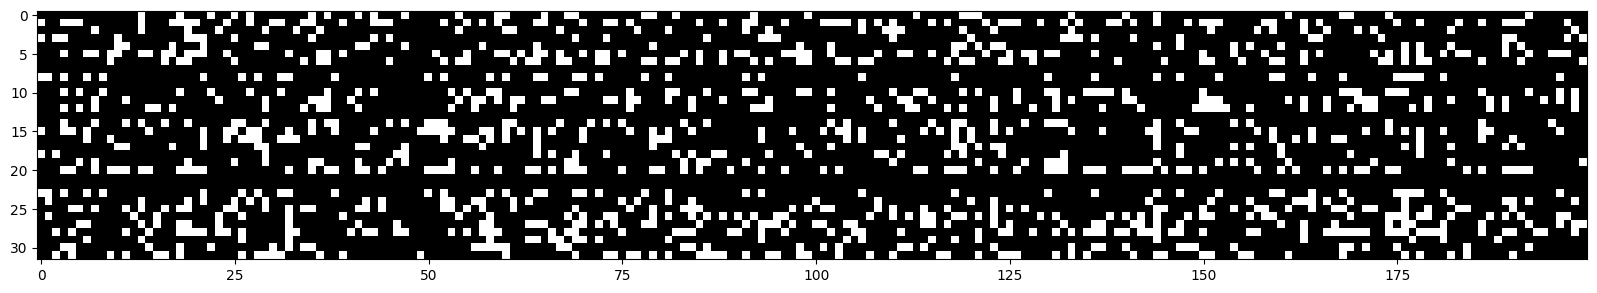

In [41]:
plt.figure(figsize=(20,10))
plt.imshow(hidden_layer.abs() > 0.99, cmap = 'gray', interpolation='nearest')

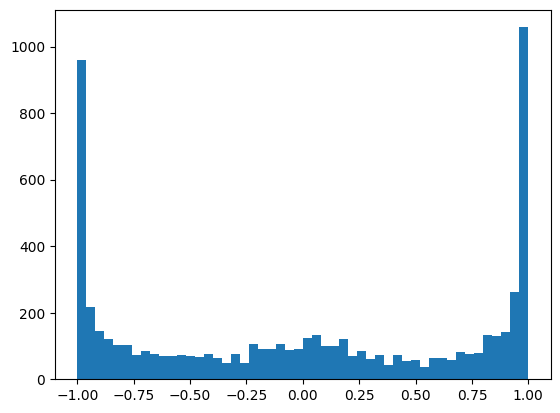

In [42]:
plt.hist(hidden_layer.view(-1).tolist(),50);

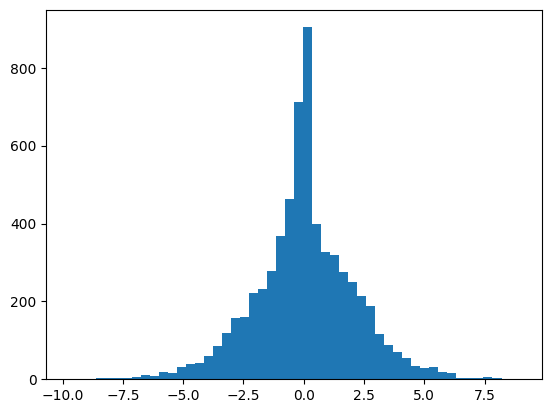

In [43]:
plt.hist(hidden_layer_preactivation.view(-1).tolist(),50);

The grpahs are correct because there are no neurons that is saturated above 0.99 in either direction.

 loss log

original <br>
train 2.124457836151123 <br>
val 2.1642823219299316

fix softmax confidently wrong <br>
train 2.0695769786834717 <br>
val 2.131199836730957

fox tanh layer too saturated at init <br>
train 2.0355966091156006 <br>
val 2.1026782989501953

### Calculating the init scale: Kaiming init

How to set the init values/scales like 0.1 or 0.2 while initialisation

tensor(0.0049) tensor(1.0041)
tensor(0.0007) tensor(3.0758)


(array([6.83502997e-06, 0.00000000e+00, 6.83502997e-06, 0.00000000e+00,
        6.83502997e-06, 2.73401199e-05, 1.36700599e-05, 4.78452098e-05,
        5.46802397e-05, 1.23030539e-04, 2.66566169e-04, 3.69091618e-04,
        6.97173057e-04, 1.21663533e-03, 2.04367396e-03, 3.41067995e-03,
        5.18095271e-03, 8.59163267e-03, 1.40869968e-02, 2.17764055e-02,
        3.17418792e-02, 4.68404604e-02, 6.35794487e-02, 8.32848401e-02,
        1.04138517e-01, 1.21977945e-01, 1.35258408e-01, 1.38464037e-01,
        1.30022775e-01, 1.16954198e-01, 9.51026070e-02, 7.46795374e-02,
        5.51791969e-02, 3.94176178e-02, 2.68821729e-02, 1.71490902e-02,
        1.10317384e-02, 6.89654524e-03, 4.38808924e-03, 2.71350690e-03,
        1.38067605e-03, 7.72358386e-04, 5.74142517e-04, 2.46061079e-04,
        1.43535629e-04, 9.56904195e-05, 6.15152697e-05, 4.78452098e-05,
        2.05050899e-05, 3.41751498e-05]),
 array([-19.94574165, -19.21421597, -18.48269028, -17.75116459,
        -17.0196389 , -16.2881

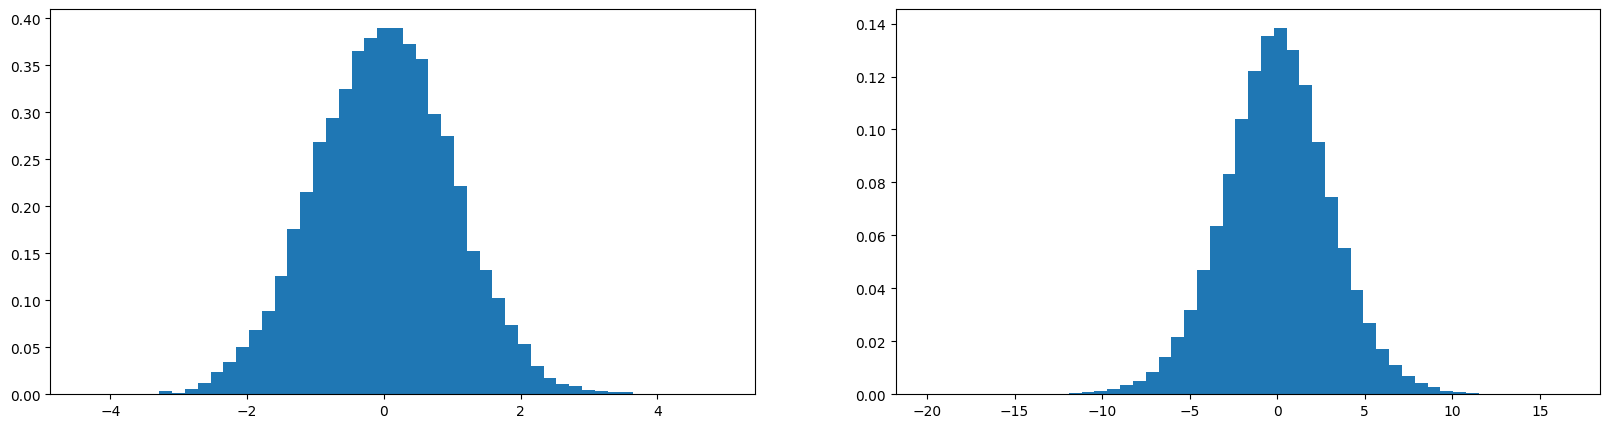

In [44]:
x = torch.randn(1000, 10)
w = torch.randn(10,200)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

We have some random x drawn from a gaussian and there are 1000 more examples that are 10 dimensional and the weight and the layer here is also initialised using gaussian.

If both are uniform gaussians and on doing x @ w with bias and non linearity not considering, so initially the mean is 0 and the std deviation which is the measure of spread of the gaussian is actually  1.

But y = x @ w is having the mean same because its a symmetric operation but the std deviation has expanded to 3 from the input std deviation of 1. Gaussian is expanding from the input and we do want the most of the neural nets to have relatively similar activations so a uniform gaussian roughly throughout the neural net. To preserve the distribution or remain a gaussian, <br>
<pre>   w = torch.randn(10,200) * 5 </pre>
then this gaussian grows because y would start taking more and more extreme values, and  <br>
<pre>   w = torch.randn(10,200) * 0.2 </pre>
makes the gaussian smaller and smaller

tensor(-0.0028) tensor(1.0038)
tensor(-0.0269) tensor(15.8716)


(array([4.63803935e-06, 6.18405247e-06, 2.31901967e-05, 3.40122886e-05,
        3.55583017e-05, 7.73006558e-05, 9.12147739e-05, 1.94797653e-04,
        2.87558440e-04, 4.51435830e-04, 6.30773351e-04, 9.94086434e-04,
        1.41614801e-03, 2.23708098e-03, 3.24817356e-03, 4.50199019e-03,
        6.24434698e-03, 8.58810286e-03, 1.15750002e-02, 1.43856520e-02,
        1.82244026e-02, 2.20863434e-02, 2.48397927e-02, 2.68279656e-02,
        2.72994996e-02, 2.65094869e-02, 2.38472523e-02, 2.00858024e-02,
        1.64186593e-02, 1.32508784e-02, 9.98724473e-03, 7.36056845e-03,
        5.39249375e-03, 3.85266469e-03, 2.65141249e-03, 1.86603783e-03,
        1.21980435e-03, 8.65767345e-04, 6.01399102e-04, 3.78773213e-04,
        2.17987849e-04, 1.31411115e-04, 1.05128892e-04, 5.87484984e-05,
        3.55583017e-05, 2.62822230e-05, 1.39141180e-05, 1.23681049e-05,
        0.00000000e+00, 7.73006558e-06]),
 array([-78.53275299, -75.29862778, -72.06450256, -68.83037735,
        -65.59625214, -62.3621

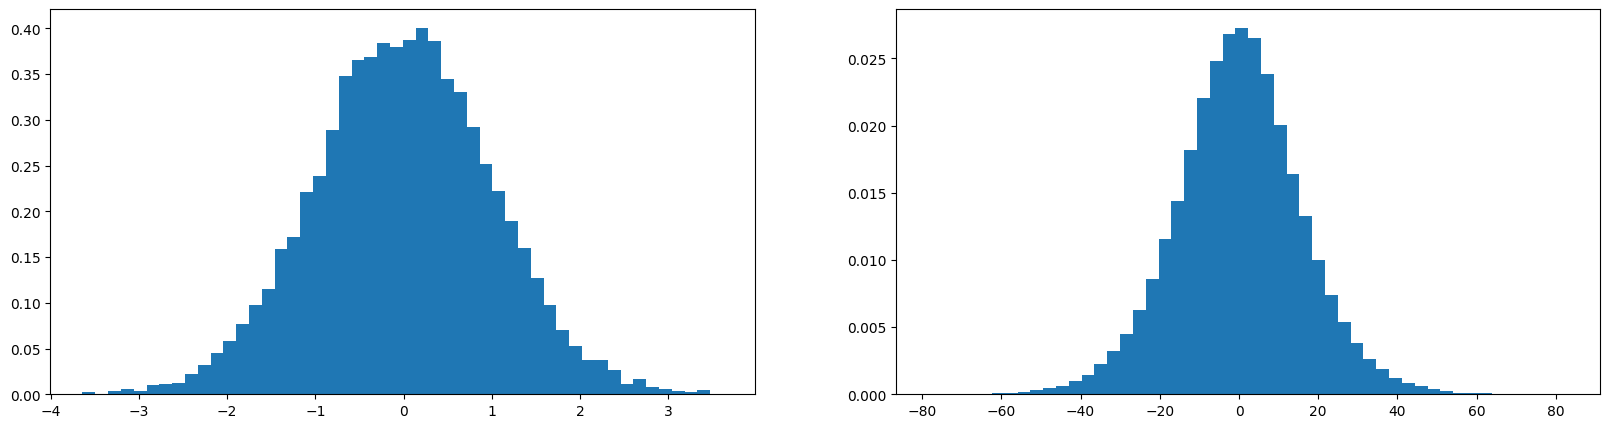

In [45]:
x = torch.randn(1000, 10)
w = torch.randn(10,200) * 5
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(-0.0013) tensor(0.9907)
tensor(0.0036) tensor(0.6293)


(array([6.70197117e-05, 1.00529568e-04, 0.00000000e+00, 1.67549279e-04,
        3.35098558e-04, 4.69137982e-04, 6.03177405e-04, 1.30688438e-03,
        2.17814063e-03, 3.65257429e-03, 6.40038247e-03, 1.11922919e-02,
        1.71905561e-02, 2.98907914e-02, 4.30936746e-02, 7.06052663e-02,
        1.10683054e-01, 1.62321742e-01, 2.31921712e-01, 3.20153163e-01,
        4.22291203e-01, 5.18833098e-01, 6.14838835e-01, 6.72375258e-01,
        6.80317093e-01, 6.34241042e-01, 5.49561636e-01, 4.56069138e-01,
        3.48804090e-01, 2.60271050e-01, 1.85946190e-01, 1.24924743e-01,
        8.36741101e-02, 5.24429244e-02, 3.41800530e-02, 2.08096205e-02,
        1.25997058e-02, 7.13759930e-03, 4.55734040e-03, 2.41270962e-03,
        1.27337452e-03, 7.70726685e-04, 5.36157694e-04, 2.68078847e-04,
        2.34568991e-04, 1.00529568e-04, 1.00529568e-04, 0.00000000e+00,
        3.35098558e-05, 3.35098558e-05]),
 array([-3.6021831 , -3.45297327, -3.30376344, -3.1545536 , -3.00534377,
        -2.85613394, 

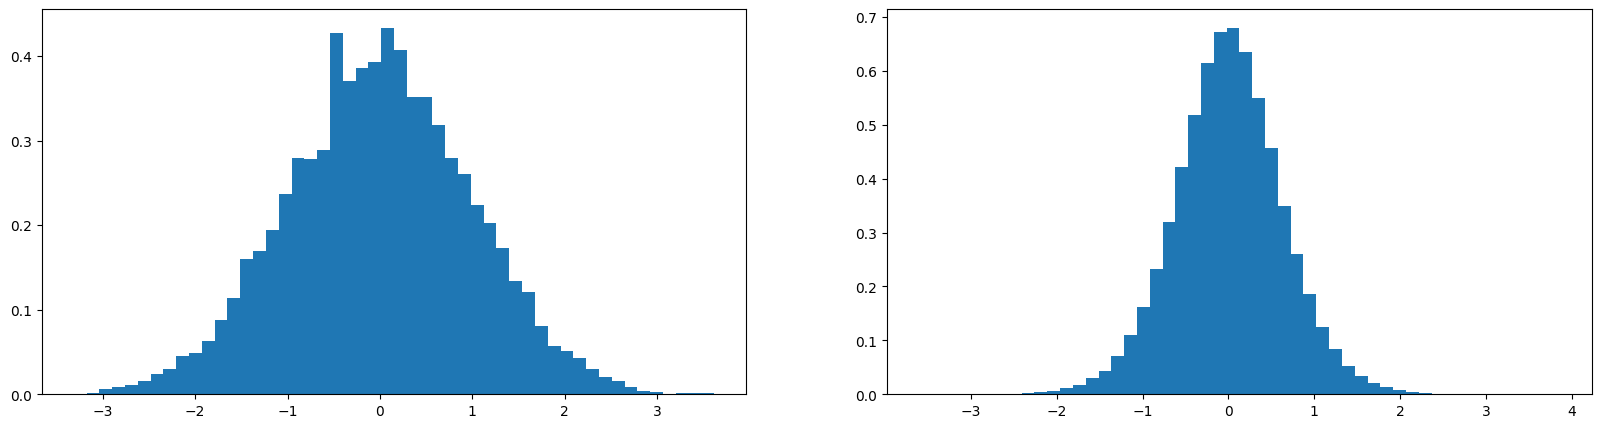

In [46]:
x = torch.randn(1000, 10)
w = torch.randn(10,200) * 0.2
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(0.0021) tensor(0.9982)
tensor(-0.0022) tensor(1.0073)


(array([2.07244448e-05, 4.14488897e-05, 6.21733345e-05, 1.86520003e-04,
        1.24346669e-04, 3.52315562e-04, 4.97386676e-04, 8.28977793e-04,
        1.67868003e-03, 3.12939117e-03, 4.12416452e-03, 8.08253348e-03,
        1.35537869e-02, 2.32528271e-02, 3.71796540e-02, 5.49612277e-02,
        8.32708193e-02, 1.21797562e-01, 1.72593177e-01, 2.35533315e-01,
        3.00711694e-01, 3.63092273e-01, 4.06282016e-01, 4.28540070e-01,
        4.05079999e-01, 3.63859078e-01, 3.08379739e-01, 2.43408604e-01,
        1.83328439e-01, 1.31268634e-01, 8.90114905e-02, 6.02874100e-02,
        3.92935474e-02, 2.37087649e-02, 1.49216003e-02, 9.18092906e-03,
        5.45052899e-03, 3.50243118e-03, 1.69940448e-03, 1.28491558e-03,
        6.21733345e-04, 2.27968893e-04, 1.86520003e-04, 1.45071114e-04,
        6.21733345e-05, 2.07244448e-05, 2.07244448e-05, 2.07244448e-05,
        0.00000000e+00, 2.07244448e-05]),
 array([-5.69117069, -5.44990971, -5.20864872, -4.96738773, -4.72612675,
        -4.48486576, 

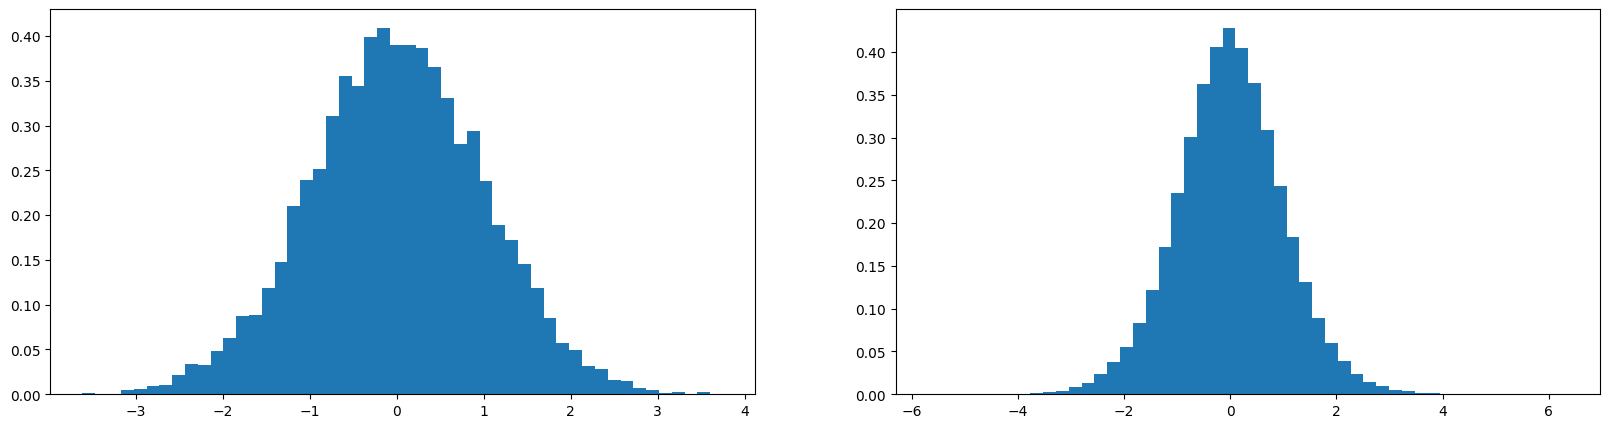

In [47]:
# to correctly preserve the std  deviation to be 1
# divide the weights by the square root of 10

x = torch.randn(1000, 10)
w = torch.randn(10,200) / 10 ** 0.5
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

These cases were widely discussed in papers like [Delving Deep into Rectifiers by Kaiming He](https://ieeexplore.ieee.org/document/7410480). They discuss especially about the ReLU and PReLU non linearity instead of tanh. 

About ReLU, since it squashes down all the negative values and just allows the positive values to just pass through, we need to make up for it by adding a  gain. They needed to initialise with a zero mean Gaussian distribution whose standard deviation is $\sqrt{2/n_l}$ which is nothing but the dimension value's square root.

Which is similar to the approach we took as in 
```python 
1/10**(-0.5)
```
but we have to add a factor of 2 here because ReLU literally throws away the half of the values and to make up for it we use this 2

In addition to this, we also study the backward propogation case to keep a check on if the gradients are also well behaving.
If one properly initialise the forward pass, the backward pass is also initialised to a costing factor that has to do with the size of the hidden neurons in the early and the late layer which is ${c_2 / d_L}$. But this doesn't matter a lot. 